In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\df_merged.csv")

In [3]:
df.head()

,solvent_ID,smiles,Binding_Energy_eV,solubility_CO2 [mol/L],viscosity [Pa s],nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,lumo_eV,homo_lumo_gap_eV,polarizability_ang3,min_partial_charge,max_partial_charge,min_abs_partial_charge,max_abs_partial_charge,vib_freq_min_cm1,vib_freq_max_cm1,vib_freq_count
0,zinc_5593217,COCCNC(=O)[C@@H](CC)C,-0.246414,0.097848,0.011764,0.0,0.0,12.906117,2.122425,4.244850,...,-6.330932,181.930993,748.130500,-0.832151,0.392923,0.034817,0.832151,23.0414,3627.7857,78.0
1,zinc_400210175,CO[C@H](C1CC1)CN1CCCCC1,-0.239933,0.117575,0.007448,0.0,1.0,17.343700,2.348592,4.557405,...,1.910386,161.701629,933.997796,-1.140739,0.562172,0.001836,1.140739,28.8558,3225.7980,96.0
2,zinc_5696920,NOCCN(C)C,-0.219656,0.097619,0.002281,0.0,1.0,7.727407,1.931852,3.863703,...,4.894440,168.343554,496.654099,-0.802413,0.379028,0.149089,0.802413,52.1440,3517.7383,51.0
3,zinc_685002938,C[C@@H](CN(CC1CC1)CC(F)F)O,-0.325154,0.088216,0.025603,0.0,1.0,14.943352,2.294945,4.451333,...,-1.984432,171.357226,807.127445,-0.794729,0.647513,0.076133,0.794729,26.9357,3729.3970,84.0
4,zinc_52602135,CNC[C@@H](C(C)C)OC,-0.288984,0.131763,0.001110,0.0,1.0,10.199109,2.119166,4.238332,...,2.317639,167.803019,655.958528,-0.847175,0.397601,0.172656,0.847175,62.5690,3522.0361,72.0


### Remove other 2 predictors when training.

In [4]:
meta_cols = ['solvent_ID', 'smiles']
# target = 'Binding_Energy_eV'  # or 'solubility_CO2 [mol/L]', 'viscosity [Pa s]'
target = 'solubility_CO2 [mol/L]'  # or 'solubility_CO2 [mol/L]', 'viscosity [Pa s]'
X = df.drop(columns=meta_cols + [target, 'viscosity [Pa s]', 'Binding_Energy_eV'])
y = df[target]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='solubility_CO2 [mol/L]', ylabel='Count'>

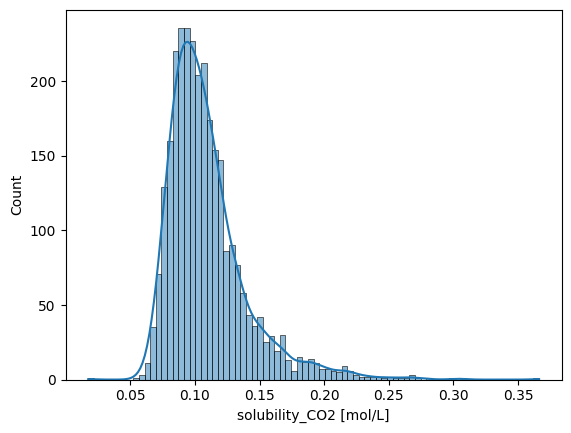

In [6]:
sns.histplot(y, kde=True)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')  # works with negatives too
y_train_trans = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [9]:
# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer(output_distribution='normal')
# y_train_trans = qt.fit_transform(y_train.values.reshape(-1, 1)).flatten()

<Axes: ylabel='Count'>

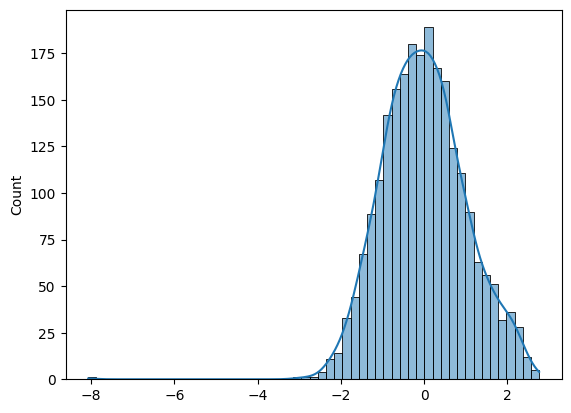

In [10]:
sns.histplot(y_train_trans, kde=True)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# # XGB model with GPU support
# xgb = XGBRegressor(
#     tree_method='gpu_hist',  # key line for GPU
#     device='cuda', 
#     random_state=42
# )

In [14]:
# # Define hyperparameter space
# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_lambda': [0.1, 1, 10]
# }

In [15]:
# # RandomizedSearchCV with GPU-based XGBoost
# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=30,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=2,
#     n_jobs=1  # must be 1 when using GPU with XGBoost
# )

In [16]:
xgb = XGBRegressor(
    tree_method='gpu_hist',
    device='cuda',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    learning_rate=0.01,
    n_estimators=500,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train_scaled, y_train_trans)

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
# # Train the model
# random_search.fit(X_train_scaled, y_train_trans)

# # Evaluate best model
# best_model = random_search.best_estimator_

Fixed RMSE: 0.0087
Fixed R²: 0.914


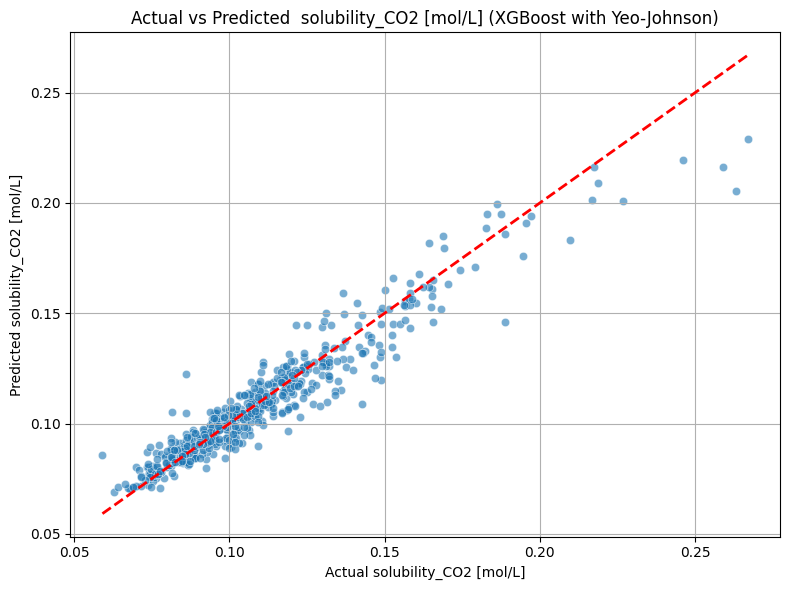

In [24]:
y_pred_trans = xgb.predict(X_test_scaled)
y_pred = pt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
# y_pred = qt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Fixed RMSE:", round(rmse, 4))
print("Fixed R²:", round(r2, 4))

# -------------------------------------
# 6. Actual vs Predicted Plot
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual solubility_CO2 [mol/L]")
plt.ylabel("Predicted solubility_CO2 [mol/L]")
plt.title("Actual vs Predicted  solubility_CO2 [mol/L] (XGBoost with Yeo-Johnson)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import shap

# Initialize SHAP explainer for tree models (GPU-safe)
# explainer = shap.Explainer(best_model)  # best_model = your trained XGBRegressor
explainer = shap.Explainer(xgb)  # best_model = your trained XGBRegressor

In [26]:
feature_names = X.columns.tolist()  # This should match the model's input

In [27]:
# Use scaled test set for SHAP input
import shap
explainer = shap.Explainer(xgb, feature_names=feature_names)
shap_values = explainer(X_test_scaled)

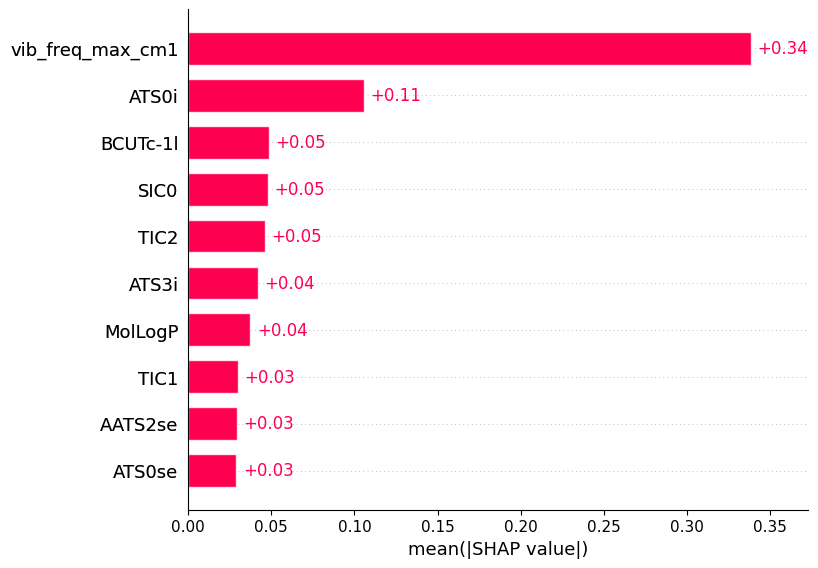

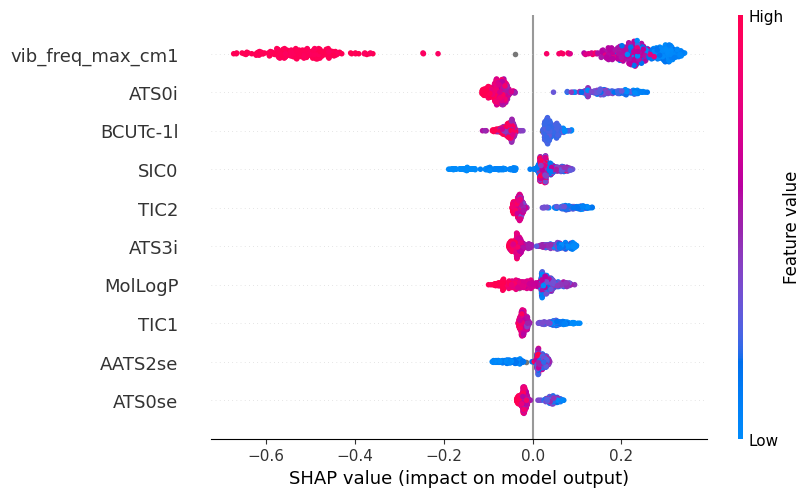

In [28]:
# Visualize top feature contributions across all samples
mean_shap = np.abs(shap_values.values).mean(axis=0)
top_10_indices = np.argsort(mean_shap)[-10:][::-1]

# Slice SHAP explanation to include only top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],
    base_values=shap_values.base_values,
    data=shap_values.data[:, top_10_indices],
    feature_names=np.array(shap_values.feature_names)[top_10_indices].tolist()
)

# Plot only top 10 features
shap.plots.bar(shap_values_top10)
shap.plots.beeswarm(shap_values_top10)


### Use actual descriptor names

### Check what descriptors we need to use

In [29]:
X_train.head(1)

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,lumo_eV,homo_lumo_gap_eV,polarizability_ang3,min_partial_charge,max_partial_charge,min_abs_partial_charge,max_abs_partial_charge,vib_freq_min_cm1,vib_freq_max_cm1,vib_freq_count
252,0.0,1.0,13.354433,2.172565,4.34513,13.354433,1.112869,3.322301,2.918824,0.243235,...,-2.036265,176.35533,749.422107,-0.805377,0.781144,0.092901,0.805377,29.8689,3736.9532,81.0


### Predicted vs Actual values (include R2 score and rmse)
### Include a histogram of residuals

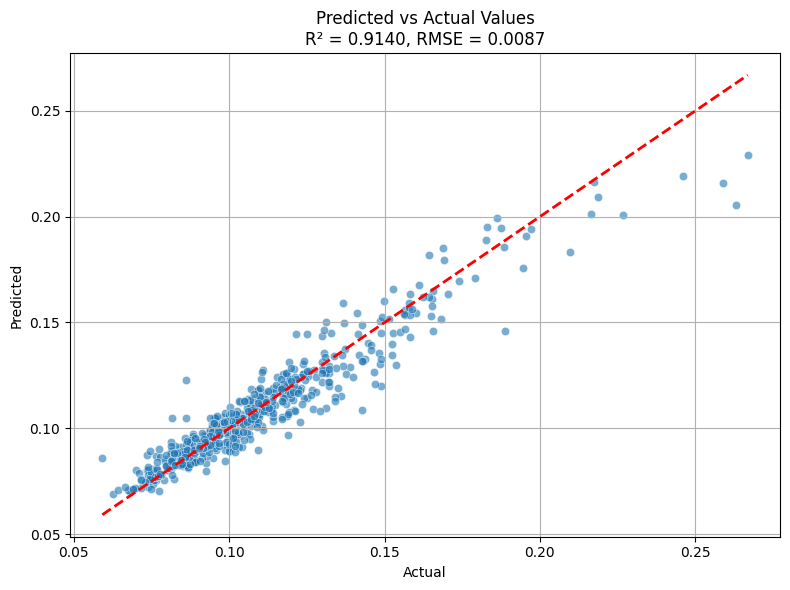

In [30]:
residuals = y_test - y_pred

# --- A. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.title(f"Predicted vs Actual Values\nR² = {r2:.4f}, RMSE = {rmse:.4f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

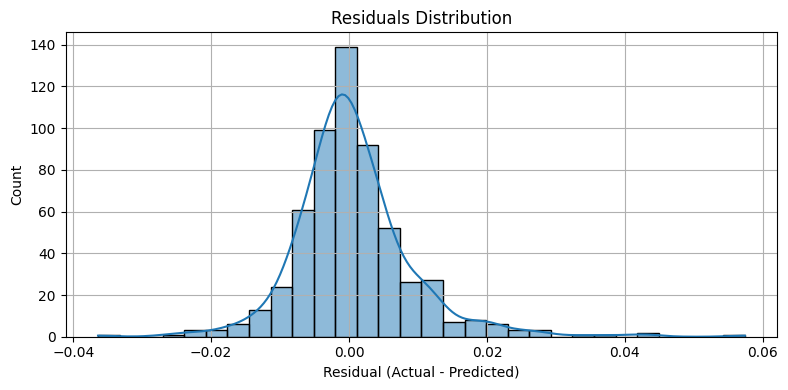

In [31]:
# --- B. Histogram of Residuals ---
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

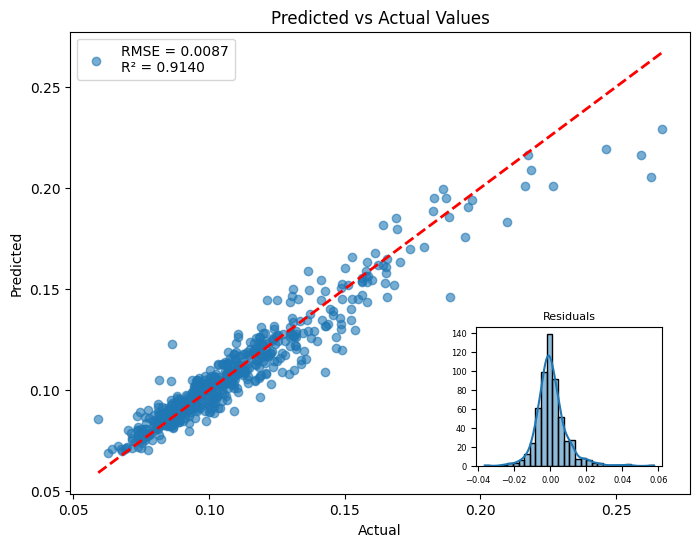

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
ax.set_title("Predicted vs Actual Values")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend([f'RMSE = {rmse:.4f}\nR² = {r2:.4f}'], loc='upper left')

# Inset Plot: Residuals Distribution
inset_ax = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2)
sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)